In [1]:
import os
import re
import json
import spacy
import pandas as pd
!pip install transformers
!pip install wandb

import torch
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
import json, os
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, matthews_corrcoef
from sklearn import preprocessing
import pandas as pd
import numpy as np
import wandb


In [2]:
%env WANDB_PROJECT=Parlementary_Data
%env WANDB_NOTEBOOK_NAME="Final Notebook_Preparing Data.ipynb"

env: WANDB_PROJECT=Parlementary_Data
env: WANDB_NOTEBOOK_NAME="Final Notebook_Preparing Data.ipynb"


# Making Parliamentary Data Searchable

In [ ]:
parl_seat = [33, 34, 35, 36, 37, 38, 39, 40, 41] #Fill here the legislatures you want to search
col_list = []

for seat in parl_seat:
    parl_df = pd.read_excel(rf"speaker_lists/speakers_leg{seat}.xlsx")
    path = rf'PATH TO LEGISLATURE\legislature{seat}' #Path to folder with all files of a legislature
    obj = os.scandir(path)
    print(seat)
    for entry in obj:
        with open(rf"legislature{seat}/{entry.name}", "r", encoding='utf-8') as f:
            session = json.load(f)
            countdown = len(session['pages']) #looks to the lenght of a session
            counter = 0
            heading = 0
            pattern = re.compile("([a-z]|\))\.\s-?—") #This pattern notices a speaker in the Third structure form. Lowercase or ending paranthesis
            suite_fin = re.compile("\(Suite\set\sfin\.\s—") #repeated ending element in the early parlementary debates of this era
            presid = re.compile("([Pp]résident|[Vv]oorzitter)\s—")#search for a common OCR mistake, but also a combination that is not abundant
        
            while counter != countdown: #when countdown and counter are the same the session has been wholly overed
                for each in session['pages'][counter]['paragraphs']:
                    check = pattern.search(each["text"]); #searches the potential of a new speaker in the new paragraph
                    check_big = re.search('\.\s—', each["text"]);
                    pointer = re.search('\.\—', each["text"]);
                    num_check = re.match('[0-9]+(\.|°)', each["text"]); #Looks to formal summaries
                    suite = suite_fin.match(each["text"]);
                    presid_check = presid.search(each["text"]);
                    double_check = re.search('.\s-—', each["text"])
                
                    if num_check and heading == 0: #finds summaries in the start of the text
                        continue
                    elif suite:
                        continue
                    elif each["text"].isdigit():
                        continue
                    elif check or presid_check:
                        if check_big and each['text'].split('. —', 1)[0] in parl_df["names"].values:
                            new_entry = each['text'].split('. —', 1)
                            load_dataset = parl_df[parl_df["names"]==new_entry[0]]
                            col_list.append([session["date"], load_dataset["uniform name"].values[0], new_entry[1], load_dataset["affiliation"].values[0], each['language'], seat, session["session"]])
                            heading +=1
                        elif pointer and each['text'].split('.—', 1)[0] in parl_df["names"].values:
                            new_entry = each['text'].split('.—', 1)
                            load_dataset = parl_df[parl_df["names"]==new_entry[0]]
                            col_list.append([session["date"], load_dataset["uniform name"].values[0], new_entry[1], load_dataset["affiliation"].values[0], each['language'], seat, session["session"]])
                            heading +=1
                        elif presid_check and each['text'].split('—', 1)[0] in parl_df["names"].values:
                            new_entry =each['text'].split('—', 1)
                            load_dataset = parl_df[parl_df["names"]==new_entry[0]]
                            col_list.append([session["date"], load_dataset["uniform name"].values[0], new_entry[1], load_dataset["affiliation"].values[0], each['language'], seat, session["session"]])
                            heading +=1
                        elif double_check and each['text'].split('. -—', 1)[0] in parl_df["names"].values:
                            new_entry =each['text'].split('. -—', 1)
                            load_dataset = parl_df[parl_df["names"]==new_entry[0]]
                            col_list.append([session["date"], load_dataset["uniform name"].values[0], new_entry[1], load_dataset["affiliation"].values[0], each['language'], seat, session["session"]])
                            heading +=1
                        else:
                            if heading == 0:
                                continue
                            else:
                                col_list.append([session["date"], col_list[-1][1], each['text'], col_list[-1][3], each['language'], seat, session["session"]])
                    elif heading == 0:
                        continue
                    elif each['text'].isupper():
                        continue
                    else:
                        col_list.append([session["date"], col_list[-1][1], each['text'], col_list[-1][3], each['language'],seat, session["session"]])#appends text to the last speaker
                counter += 1


<>:15: SyntaxWarning: invalid escape sequence '\)'
<>:16: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\.'
<>:23: SyntaxWarning: invalid escape sequence '\.'
<>:24: SyntaxWarning: invalid escape sequence '\.'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\)'
<>:16: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\.'
<>:23: SyntaxWarning: invalid escape sequence '\.'
<>:24: SyntaxWarning: invalid escape sequence '\.'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\1971257604.py:15: SyntaxWarning: invalid escape sequence '\)'
  pattern = re.compile("([a-z]|\))\.\s-?—") #This pattern notices a speaker in the Third structure form. Lowercase or ending paranthesis
C:\Users\tomhe\AppData\Local\Temp\ipy

33
34
35
36
37
38
39
40
41


In [ ]:
df = pd.DataFrame(col_list, columns=["Date", "Name", "Speech", "Party", "lang", "Legislature", "Session_ID"])
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Name,Speech,Party,lang,Legislature
0,1946-01-09,"Rulot, Narcisse","N. M. B. S. (Materieel, personeel, electrific...",NaN,nl,33
1,1946-01-09,"Rulot, Narcisse","Vaes, A............",NaN,nl,33
2,1946-01-09,"Rulot, Narcisse",Piérard.............,NaN,fr,33
3,1946-01-09,"Rulot, Narcisse",Rey................,NaN,fr,33
4,1946-01-09,"Rulot, Narcisse",29 Mei 1946,NaN,nl,33
...,...,...,...,...,...,...
2977256,1974-01-17,Président_Voorzitter,Article 71 du règlement,NaN,fr,41
2977257,1974-01-17,Président_Voorzitter,Des questions ont été remises au bureau par MM...,NaN,nl,41
2977258,1974-01-17,Président_Voorzitter,Schriftelijke vragen en antwoorden,NaN,nl,41
2977259,1974-01-17,Président_Voorzitter,Artikel 71 van het reglement,NaN,nl,41


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977261 entries, 0 to 2977260
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Date         datetime64[ns]
 1   Name         object        
 2   Speech       object        
 3   Party        object        
 4   lang         object        
 5   Legislature  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 136.3+ MB


## Preparing the dataset

To have a clear dataset we need to clear out a few things.

We get rid of the Parliament President, because what he or she says are formal notifications and often littered with unclear data. Only keep it when necessary for your investigation. Remember that in this dataset the President is anonimized, because the speaker data is not determined in time and changes in president often also occur during the legislature.

In [6]:
parl = df[df["Name"] != "Président_Voorzitter"]
parl

,Date,Name,Speech,Party,lang,Legislature
0,1946-01-09,"Rulot, Narcisse","N. M. B. S. (Materieel, personeel, electrific...",NaN,nl,33
1,1946-01-09,"Rulot, Narcisse","Vaes, A............",NaN,nl,33
2,1946-01-09,"Rulot, Narcisse",Piérard.............,NaN,fr,33
3,1946-01-09,"Rulot, Narcisse",Rey................,NaN,fr,33
4,1946-01-09,"Rulot, Narcisse",29 Mei 1946,NaN,nl,33
...,...,...,...,...,...,...
2977245,1974-01-17,"Parisis, Albert",Je vous demande de faire établir une statistiq...,PSC,fr,41
2977246,1974-01-17,"Parisis, Albert",Vous contaterez que le délai est beaucoup plus...,PSC,fr,41
2977247,1974-01-17,"Olivier, Louis",Je vais faire établir ce document pour les tr...,PLP,fr,41
2977248,1974-01-17,"Olivier, Louis",Je pense avoir rencontré les différents élémen...,PLP,fr,41


A common misspelling, just standardized for lazyness sake.

In [7]:
parl = parl.replace("Dejace, Théo", "Dejace, Theo")
parl

,Date,Name,Speech,Party,lang,Legislature
0,1946-01-09,"Rulot, Narcisse","N. M. B. S. (Materieel, personeel, electrific...",NaN,nl,33
1,1946-01-09,"Rulot, Narcisse","Vaes, A............",NaN,nl,33
2,1946-01-09,"Rulot, Narcisse",Piérard.............,NaN,fr,33
3,1946-01-09,"Rulot, Narcisse",Rey................,NaN,fr,33
4,1946-01-09,"Rulot, Narcisse",29 Mei 1946,NaN,nl,33
...,...,...,...,...,...,...
2977245,1974-01-17,"Parisis, Albert",Je vous demande de faire établir une statistiq...,PSC,fr,41
2977246,1974-01-17,"Parisis, Albert",Vous contaterez que le délai est beaucoup plus...,PSC,fr,41
2977247,1974-01-17,"Olivier, Louis",Je vais faire établir ce document pour les tr...,PLP,fr,41
2977248,1974-01-17,"Olivier, Louis",Je pense avoir rencontré les différents élémen...,PLP,fr,41


In [8]:
parl = parl.fillna("UNK")
parl

,Date,Name,Speech,Party,lang,Legislature
0,1946-01-09,"Rulot, Narcisse","N. M. B. S. (Materieel, personeel, electrific...",UNK,nl,33
1,1946-01-09,"Rulot, Narcisse","Vaes, A............",UNK,nl,33
2,1946-01-09,"Rulot, Narcisse",Piérard.............,UNK,fr,33
3,1946-01-09,"Rulot, Narcisse",Rey................,UNK,fr,33
4,1946-01-09,"Rulot, Narcisse",29 Mei 1946,UNK,nl,33
...,...,...,...,...,...,...
2977245,1974-01-17,"Parisis, Albert",Je vous demande de faire établir une statistiq...,PSC,fr,41
2977246,1974-01-17,"Parisis, Albert",Vous contaterez que le délai est beaucoup plus...,PSC,fr,41
2977247,1974-01-17,"Olivier, Louis",Je vais faire établir ce document pour les tr...,PLP,fr,41
2977248,1974-01-17,"Olivier, Louis",Je pense avoir rencontré les différents élémen...,PLP,fr,41


In [9]:
parl["lang"].value_counts(normalize=True)

lang
fr     0.580368
nl     0.384894
n/a    0.034738
Name: proportion, dtype: float64

In [10]:
#Language split
parl_fr = parl[parl["lang"] == "fr"]
parl_nl = parl[parl["lang"] == "nl"]

In [11]:
parl_fr.drop_duplicates(inplace=True)
parl_fr.shape

C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\201118081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_fr.drop_duplicates(inplace=True)


(869563, 6)

In [12]:
parl_nl.drop_duplicates(inplace=True)
parl_nl.shape

C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\2224666666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_nl.drop_duplicates(inplace=True)


(565096, 6)

In [13]:
party_list = list(set(parl_nl["Party"]))
app_list = []
party_list = [str(element) for element in party_list]
party_list
le = preprocessing.LabelEncoder()
le.fit(party_list)
parl_nl["Party_code"] = le.transform(parl_nl["Party"])
parl_fr["Party_code"] = le.transform(parl_fr["Party"])


C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\801179136.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_nl["Party_code"] = le.transform(parl_nl["Party"])
C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\801179136.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_fr["Party_code"] = le.transform(parl_fr["Party"])


In [14]:
parl_nl

,Date,Name,Speech,Party,lang,Legislature,Party_code
0,1946-01-09,"Rulot, Narcisse","N. M. B. S. (Materieel, personeel, electrific...",UNK,nl,33,23
1,1946-01-09,"Rulot, Narcisse","Vaes, A............",UNK,nl,33,23
4,1946-01-09,"Rulot, Narcisse",29 Mei 1946,UNK,nl,33,23
7,1946-01-09,"Rulot, Narcisse","AUTEURS, SPREKERS of onderbrekingen",UNK,nl,33,23
9,1946-01-09,"Rulot, Narcisse",Verkeerswezen (vervolg),UNK,nl,33,23
...,...,...,...,...,...,...,...
2977118,1974-01-17,"Gillet, Roland",Vergaderingen van donderdag 17 januari 1974,PVV_PLP_BRUX,nl,41,16
2977176,1974-01-17,"Parisis, Albert",Vergaderingen van donderdag 17 januari 1974,PSC,nl,41,12
2977207,1974-01-17,"Olivier, Louis",Annales parlementaires — Parlementaire Handeli...,PLP,nl,41,10
2977208,1974-01-17,"Olivier, Louis",Chambre des représentants — Kamer van volksver...,PLP,nl,41,10


In [15]:
d = {}
for element in set(parl_nl["Party"]):
    val = parl_nl[parl_nl["Party"]==element]
    mom = set(val["Party_code"])
    d.update({element:mom})
d

{'RW': {20},
 'RSCL': {19},
 'PSB': {11},
 'PSC': {12},
 'Rassemblement National': {21},
 'PVV_PLP_BRUX': {16},
 'CVV': {2},
 'Volksunie': {24},
 'UNK': {23},
 'UDB': {22},
 'Front Wallon': {5},
 'PVV_PLP': {15},
 'PVV': {14},
 'BSP_PSB': {1},
 'LP_PL': {8},
 'KPB_PCB': {7},
 'KPB': {6},
 'PLP': {10},
 'BSP': {0},
 'FDF': {4},
 'Christelijke Volkspartij': {3},
 'Parti Wallon des Travailleurs': {18},
 'Parti Social Indépendant': {17},
 'PCB': {9},
 'PSC_CVP': {13}}

In [16]:
parl_fr

,Date,Name,Speech,Party,lang,Legislature,Party_code
2,1946-01-09,"Rulot, Narcisse",Piérard.............,UNK,fr,33,23
3,1946-01-09,"Rulot, Narcisse",Rey................,UNK,fr,33,23
38,1946-01-09,"Rulot, Narcisse",Dispy .............,UNK,fr,33,23
39,1946-01-09,"Rulot, Narcisse",Brunfaut ...........,UNK,fr,33,23
40,1946-01-09,"Rulot, Narcisse",Major .............,UNK,fr,33,23
...,...,...,...,...,...,...,...
2977245,1974-01-17,"Parisis, Albert",Je vous demande de faire établir une statistiq...,PSC,fr,41,12
2977246,1974-01-17,"Parisis, Albert",Vous contaterez que le délai est beaucoup plus...,PSC,fr,41,12
2977247,1974-01-17,"Olivier, Louis",Je vais faire établir ce document pour les tr...,PLP,fr,41,10
2977248,1974-01-17,"Olivier, Louis",Je pense avoir rencontré les différents élémen...,PLP,fr,41,10


### Tokenization

This has been done with an example containing communism. Where are the paragraphs containing the word communism and variants? First we need to select the paragraphs containing these words and to isolate them to work with them. This method can be used to apply it to other words if you just simply replace the word communism. 

In [17]:
!pip install nltk

In [18]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tomhe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [19]:
import string

def remove_punct(input_string):
    result = ''.join([char for char in input_string if char not in string.punctuation])
    return result

parl_nl["Tokenized_Speech"] = parl_nl["Speech"].apply(remove_punct)
parl_fr["Tokenized_Speech"] = parl_fr["Speech"].apply(remove_punct)

parl_nl["Tokenized_Speech"] = parl_nl["Tokenized_Speech"].apply(word_tokenize)
parl_fr["Tokenized_Speech"] = parl_fr["Tokenized_Speech"].apply(word_tokenize)


C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\4081510889.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_nl["Tokenized_Speech"] = parl_nl["Speech"].apply(remove_punct)
C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\4081510889.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_fr["Tokenized_Speech"] = parl_fr["Speech"].apply(remove_punct)
C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\4081510889.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [ ]:
#Create lists with the desired words and their equivalents in the target language
Theme = 'Communism' #Set theme or topic, for later formalization
woordenlijst_nl = ["kommunisme", "kommunist", "kommunisten", "communist", "communisten", "communisme", "bolsjewist", "bolsjewisten", "bolsjewisme", "bolsjevisme", "bolsjevist", "marxisme", "marxisten", "marxist"]
vocabulaire_fr = ["communisme", "communiste", "communistes", "bolchevisme", "bolcheviste", "marxisme", "marxiste", "marxistes"]

parl_nl = parl_nl[parl_nl["Tokenized_Speech"].apply(lambda word_list : any(word in woordenlijst_nl for word in word_list))]
parl_fr = parl_fr[parl_fr["Tokenized_Speech"].apply(lambda word_list : any(word in vocabulaire_fr for word in word_list))]




In [21]:
print(parl_nl.shape)
print(parl_fr.shape)

(364, 8)
(6121, 8)


In [22]:
parl_fr["Party"].value_counts(normalize=True)

Party
KPB_PCB                          0.516256
BSP_PSB                          0.215651
PSC_CVP                          0.154223
LP_PL                            0.049012
PCB                              0.019768
PVV_PLP                          0.019278
RW                               0.005555
KPB                              0.004738
Parti Wallon des Travailleurs    0.003758
UNK                              0.002287
PSB                              0.002287
Front Wallon                     0.001797
BSP                              0.001470
FDF                              0.001144
PSC                              0.000817
Parti Social Indépendant         0.000653
PVV_PLP_BRUX                     0.000653
Rassemblement National           0.000163
PLP                              0.000163
PVV                              0.000163
Volksunie                        0.000163
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Mention of Communism in French interpellations of the Belgian Chamber')

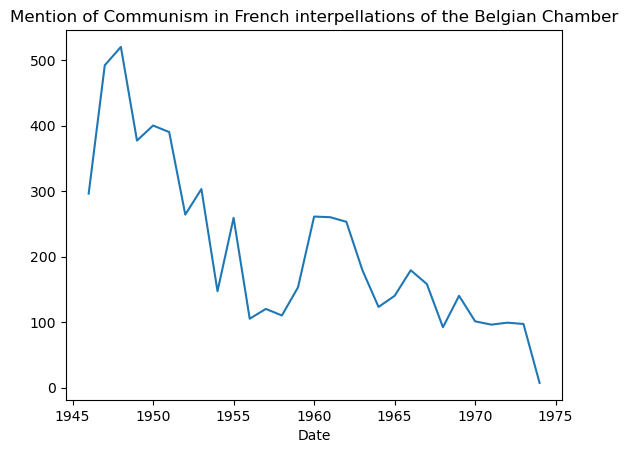

In [ ]:
import matplotlib.pyplot as plt
parl_fr.groupby(parl_fr['Date'].dt.year).size().plot()
plt.xlabel('Year')
plt.ylabel(f'Mentions of {Theme} (Absolute)')
plt.title(f'Mention of {Theme} in French interpellations of the Belgian Chamber')

Text(0.5, 1.0, 'Debates concerning Communism in Dutch interpellations of the Belgian Chamber')

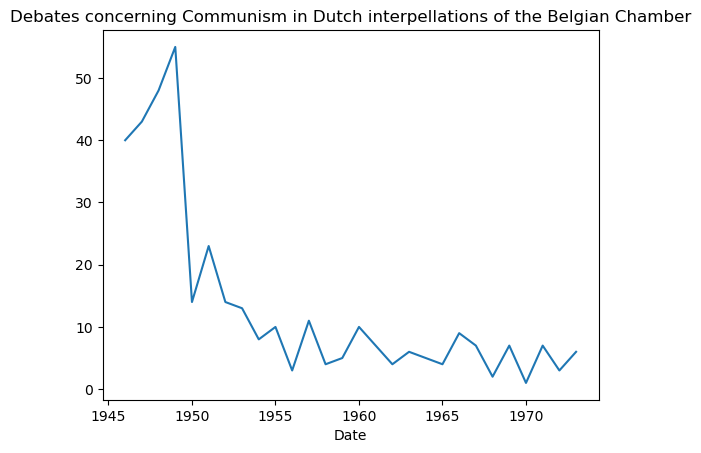

In [ ]:
parl_nl.groupby(parl_nl['Date'].dt.year).size().plot()
plt.xlabel('Year')
plt.ylabel(f'Mentions of {Theme} (Absolute)')
plt.title(f'Debates concerning {Theme} in Dutch interpellations of the Belgian Chamber')

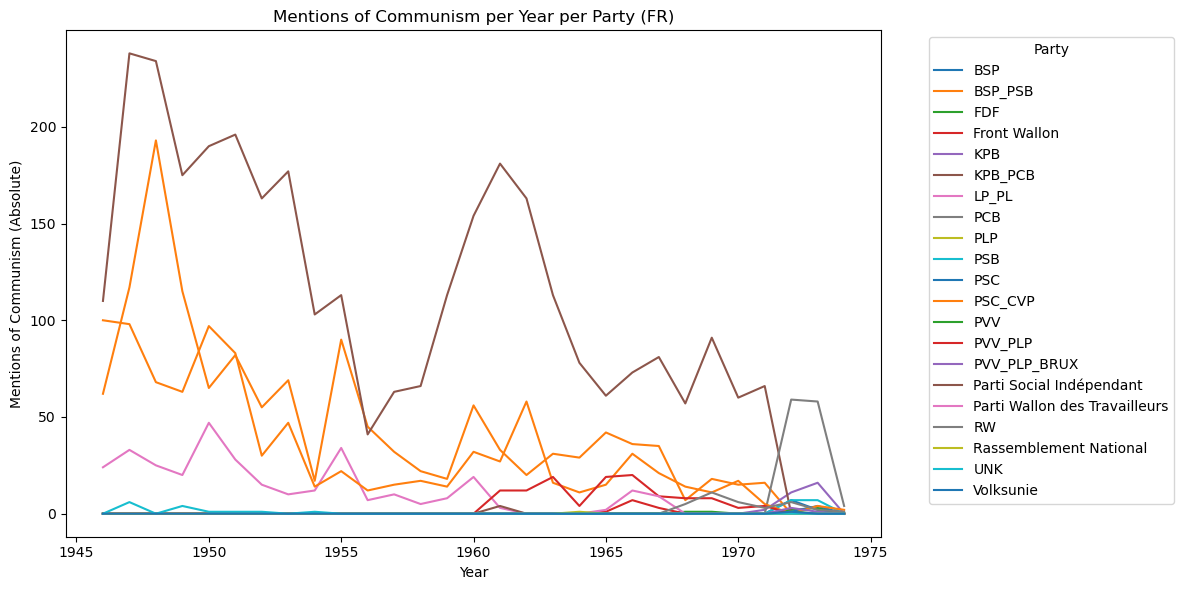

In [25]:
#Misschien tokenizen voor de split en dan kan je dit voor alles in totaal
import matplotlib.pyplot as plt

speech_counts = parl_fr.groupby([parl_fr['Date'].dt.year, 'Party']).size().unstack(fill_value=0)

speech_counts.plot(figsize=(12, 6))

plt.title(f'Mentions of {Theme} per Year per Party (FR)')
plt.xlabel('Year')
plt.ylabel(f'Mentions of {Theme} (Absolute)')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

                 

## Vectorization

To really work with the words and generate meaningful relations we need to vectorize the words and/or sentences.

In [26]:
!pip install flair

In [27]:
from flair.embeddings import WordEmbeddings

In [28]:
from sentence_transformers import SentenceTransformer

BERT_nl_sentence_transfo = SentenceTransformer("NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers")

In [29]:
BERT_fr_sentence_transfo = SentenceTransformer("dangvantuan/sentence-camembert-base")

In [30]:
!python -m spacy download nl_core_news_sm
!python -m spacy download fr_core_news_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 5.6 MB/s eta 0:00:03
     - -------------------------------------- 0.6/12.8 MB 7.5 MB/s eta 0:00:02
     -- ------------------------------------- 0.8/12.8 MB 8.5 MB/s eta 0:00:02
     -- ------------------------------------- 0.9/12.8 MB 5.8 MB/s eta 0:00:03
     ----- ---------------------------------- 1.6/12.8 MB 8.1 MB/s eta 0:00:02
     ----- ---------------------------------- 1.8/12.8 MB 7.5 MB/s eta 0:00:02
     ------ --------------------------------- 2.0/12.8 MB 7.3 MB/s eta 0:00:02
     -------- ------------------------------- 2.8/12.8 MB 8.4 MB/s eta 0:00:02
     ---------- ----------------------------- 3.3/12.8 MB 9.2 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 9.0 MB/s eta 0:00:02
     ----------- ---------------------------- 3.8/12.8 MB 8.6 MB/s eta 0:00:02
     ------------ --------------------------- 4.0/12.8 MB 8

In [31]:
import spacy
from spacy.lang.nl.examples import sentences 
from spacy.lang.fr.examples import sentences 


nlp_fr = spacy.load("fr_core_news_sm")
nlp_nl = spacy.load("nl_core_news_sm")

def sent_tok_fr(txt):
    for sent in nlp_fr(txt).sents:
        if sent.text == ' ':
            return txt
        else:
            return sent.text

def sent_tok_nl(txt):
    for sent in nlp_nl(txt).sents:
        if sent.text == ' ':
            return txt
        else:
            return sent.text

In [32]:
parl_fr["Embedded_Sentence"] = parl_fr["Speech"].apply(sent_tok_fr)
parl_nl["Embedded_Sentence"] = parl_nl["Speech"].apply(sent_tok_nl)

C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\1527561901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_fr["Embedded_Sentence"] = parl_fr["Speech"].apply(sent_tok_fr)
C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\1527561901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_nl["Embedded_Sentence"] = parl_nl["Speech"].apply(sent_tok_nl)


In [33]:
parl_fr["Embedded_Sentence"].values[1]

'Je dois ajouter que Je groupe P. S. C. n’est pas favorable à une extension du nombre des mandats au sein du bureau.'

In [34]:
parl_fr

,Date,Name,Speech,Party,lang,Legislature,Party_code,Tokenized_Speech,Embedded_Sentence
1535,1946-03-19,"Bohy, Georges","Mesdames, messieurs, au nom de la gauche soci...",PSC_CVP,fr,33,13,"[Mesdames, messieurs, au, nom, de, la, gauche,...","Mesdames, messieurs, au nom de la gauche soci..."
1552,1946-03-19,"De Schryver, August",Je dois ajouter que Je groupe P. S. C. n’est p...,PSC_CVP,fr,33,13,"[Je, dois, ajouter, que, Je, groupe, P, S, C, ...",Je dois ajouter que Je groupe P. S. C. n’est p...
1559,1946-03-19,"Herssens, Sam","Mesdames, messieurs, je voudrais exprimer le ...",KPB_PCB,fr,33,7,"[Mesdames, messieurs, je, voudrais, exprimer, ...","Mesdames, messieurs, je voudrais exprimer le ..."
1560,1946-03-19,"Herssens, Sam",M. Devèze n'y voit pas une question politique ...,KPB_PCB,fr,33,7,"[M, Devèze, ny, voit, pas, une, question, poli...",M. Devèze n'y voit pas une question politique ...
1561,1946-03-19,"Herssens, Sam",C’est pourquoi nous ne pouvons marquer notre a...,KPB_PCB,fr,33,7,"[C, ’, est, pourquoi, nous, ne, pouvons, marqu...",C’est pourquoi
...,...,...,...,...,...,...,...,...,...
2966638,1974-01-08,"Delrue, André",C’est pourquoi le groupe communiste de la Cham...,PCB,fr,41,9,"[C, ’, est, pourquoi, le, groupe, communiste, ...",C’est pourquoi
2970740,1974-01-10,"Couteau, Marcel","Revoyez, Monsieur le Ministre, votre projet ca...",PCB,fr,41,9,"[Revoyez, Monsieur, le, Ministre, votre, proje...","Revoyez, Monsieur le Ministre, votre projet"
2970806,1974-01-10,"Vanden Boeynants, Paul",Puisque M. Couteau parle de la presse du Parti...,PSC_CVP,fr,41,13,"[Puisque, M, Couteau, parle, de, la, presse, d...",Puisque M. Couteau parle de la presse du Parti...
2970808,1974-01-10,"Vanden Boeynants, Paul",Et il s’agit de l’organe central du Parti comm...,PSC_CVP,fr,41,13,"[Et, il, s, ’, agit, de, l, ’, organe, central...",Et il s’agit de l’organe central du Parti comm...


In [35]:
parl_fr["Embedded_Sentence"] = parl_fr["Embedded_Sentence"].apply(BERT_fr_sentence_transfo.encode)
parl_nl["Embedded_Sentence"] = parl_nl["Embedded_Sentence"].apply(BERT_nl_sentence_transfo.encode)

C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\3265193258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_fr["Embedded_Sentence"] = parl_fr["Embedded_Sentence"].apply(BERT_fr_sentence_transfo.encode)
C:\Users\tomhe\AppData\Local\Temp\ipykernel_42788\3265193258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parl_nl["Embedded_Sentence"] = parl_nl["Embedded_Sentence"].apply(BERT_nl_sentence_transfo.encode)


In [36]:
parl_fr

,Date,Name,Speech,Party,lang,Legislature,Party_code,Tokenized_Speech,Embedded_Sentence
1535,1946-03-19,"Bohy, Georges","Mesdames, messieurs, au nom de la gauche soci...",PSC_CVP,fr,33,13,"[Mesdames, messieurs, au, nom, de, la, gauche,...","[0.03333364, 0.049680166, 0.010493976, 0.08941..."
1552,1946-03-19,"De Schryver, August",Je dois ajouter que Je groupe P. S. C. n’est p...,PSC_CVP,fr,33,13,"[Je, dois, ajouter, que, Je, groupe, P, S, C, ...","[-0.067432806, -0.15957542, -0.24366844, 0.018..."
1559,1946-03-19,"Herssens, Sam","Mesdames, messieurs, je voudrais exprimer le ...",KPB_PCB,fr,33,7,"[Mesdames, messieurs, je, voudrais, exprimer, ...","[-0.030235484, -0.16132435, -0.19439079, 0.059..."
1560,1946-03-19,"Herssens, Sam",M. Devèze n'y voit pas une question politique ...,KPB_PCB,fr,33,7,"[M, Devèze, ny, voit, pas, une, question, poli...","[-0.024009524, -0.029678293, 0.06657404, 0.051..."
1561,1946-03-19,"Herssens, Sam",C’est pourquoi nous ne pouvons marquer notre a...,KPB_PCB,fr,33,7,"[C, ’, est, pourquoi, nous, ne, pouvons, marqu...","[0.04392912, -0.18461783, 0.16979522, 0.047884..."
...,...,...,...,...,...,...,...,...,...
2966638,1974-01-08,"Delrue, André",C’est pourquoi le groupe communiste de la Cham...,PCB,fr,41,9,"[C, ’, est, pourquoi, le, groupe, communiste, ...","[0.04392912, -0.18461783, 0.16979522, 0.047884..."
2970740,1974-01-10,"Couteau, Marcel","Revoyez, Monsieur le Ministre, votre projet ca...",PCB,fr,41,9,"[Revoyez, Monsieur, le, Ministre, votre, proje...","[-0.023509225, -0.122006945, 0.05867369, 0.059..."
2970806,1974-01-10,"Vanden Boeynants, Paul",Puisque M. Couteau parle de la presse du Parti...,PSC_CVP,fr,41,13,"[Puisque, M, Couteau, parle, de, la, presse, d...","[-0.1162586, -0.1321392, 0.014251332, 0.161171..."
2970808,1974-01-10,"Vanden Boeynants, Paul",Et il s’agit de l’organe central du Parti comm...,PSC_CVP,fr,41,13,"[Et, il, s, ’, agit, de, l, ’, organe, central...","[-0.08132222, 0.0334341, -0.057914276, 0.01954..."


In [ ]:
# Merge the Dutch and Frech ones (optional)

parl_combo = pd.concat(parl_fr, parl_nl)

## Export the data

### Full Topic Data Export

In [ ]:
parl_combo.to_csv("export_parl_data.csv", index=False)

### Data Export per Party

In [ ]:
parties = set(list(parl_combo["Party"]))

for party in parties:
    party_df = parl_combo[parl_combo["Party"] == party]
    party_df.to_csv(rf'export_{party}_data.csv', index=False)
